## Package

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from KANConv import KAN_Convolutional_Layer, KANLinear
from architectures.CKAN_BN import CKAN_BN

## Dataset

In [5]:
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = CIFAR10(root='./data', train=True, download=True, transform=transform)

mnist_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

## Train & Test

In [6]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    # Set the model to training mode
    model.to(device)
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    # Switch the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

## Comon Models

In [13]:
import torch.nn.functional as F
from architectures.SimpleModels import *
from architectures.ConvNet import ConvNet
from architectures.KANConvs_MLP import CKAN


## Convolutional KAN

In [11]:
from architectures.KKAN import KKAN_Convolutional_Network


In [7]:
def train_model(model, device, train_loader, test_loader, optimizer, criterion, epochs, scheduler):
    # Track metrics
    all_train_loss = []
    all_test_loss = []
    all_test_accuracy = []
    all_test_precision = []
    all_test_recall = []
    all_test_f1 = []
    
    for epoch in range(1, epochs + 1):
        # Train the model
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        all_train_loss.append(train_loss)
        
        # Test the model
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, device, test_loader, criterion)
        all_test_loss.append(test_loss)
        all_test_accuracy.append(test_accuracy)
        all_test_precision.append(test_precision)
        all_test_recall.append(test_recall)
        all_test_f1.append(test_f1)

        scheduler.step()
    
    return all_train_loss, all_test_loss, all_test_accuracy, all_test_precision, all_test_recall, all_test_f1

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instanciar el modelo
model_SimpleCNN = SimpleCNN()
model_SimpleCNN.to(device)
optimizer_SimpleCNN = optim.AdamW(model_SimpleCNN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN, gamma=0.8)
criterion_SimpleCNN = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN, all_test_loss_SimpleCNN, all_test_accuracy_SimpleCNN, all_test_precision_SimpleCNN, all_test_recall_SimpleCNN, all_test_f1_SimpleCNN = train_model(model_SimpleCNN, device, train_loader, test_loader, optimizer_SimpleCNN, criterion_SimpleCNN, epochs=10, scheduler=scheduler_SimpleCNN)



model_SimpleLinear = SimpleLinear()
model_SimpleLinear.to(device)
optimizer_SimpleLinear = optim.AdamW(model_SimpleLinear.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleLinear = optim.lr_scheduler.ExponentialLR(optimizer_SimpleLinear, gamma=0.8)
criterion_SimpleLinear = nn.CrossEntropyLoss()
all_train_loss_SimpleLinear, all_test_loss_SimpleLinear, all_test_accuracy_SimpleLinear, all_test_precision_SimpleLinear, all_test_recall_SimpleLinear, all_test_f1_SimpleLinear = train_model(model_SimpleLinear, device, train_loader, test_loader, optimizer_SimpleLinear, criterion_SimpleLinear, epochs=10, scheduler=scheduler_SimpleLinear)

model_ConvNet = ConvNet()
model_ConvNet.to(device)
optimizer_ConvNet = optim.AdamW(model_ConvNet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_ConvNet = optim.lr_scheduler.ExponentialLR(optimizer_ConvNet, gamma=0.8)
criterion_ConvNet = nn.CrossEntropyLoss()
all_train_loss_ConvNet, all_test_loss_ConvNet, all_test_accuracy_ConvNet, all_test_precision_ConvNet, all_test_recall_ConvNet, all_test_f1_ConvNet = train_model(model_ConvNet, device, train_loader, test_loader, optimizer_ConvNet, criterion_ConvNet, epochs=10, scheduler=scheduler_ConvNet)


Epoch: 1


100%|█████████▉| 934/938 [00:21<00:00, 49.27it/s]c:\Users\MSI\anaconda3\envs\ckan\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 938/938 [00:21<00:00, 42.92it/s]


Training set: Average loss: 0.290261

Test set: Average loss: 0.0025, Accuracy: 9542/10000 (95%), Precision: 0.95, Recall: 0.95, F1 Score: 0.95

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 46.44it/s]


Training set: Average loss: 0.124344

Test set: Average loss: 0.0018, Accuracy: 9685/10000 (97%), Precision: 0.97, Recall: 0.97, F1 Score: 0.97

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 47.22it/s]


Training set: Average loss: 0.093803

Test set: Average loss: 0.0015, Accuracy: 9715/10000 (97%), Precision: 0.97, Recall: 0.97, F1 Score: 0.97

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 47.23it/s]


Training set: Average loss: 0.077732

Test set: Average loss: 0.0013, Accuracy: 9742/10000 (97%), Precision: 0.97, Recall: 0.97, F1 Score: 0.97

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 48.16it/s]


Training set: Average loss: 0.068055

Test set: Average loss: 0.0012, Accuracy: 9763/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 49.44it/s]


Training set: Average loss: 0.062097

Test set: Average loss: 0.0012, Accuracy: 9765/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 47.76it/s]


Training set: Average loss: 0.056652

Test set: Average loss: 0.0012, Accuracy: 9769/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 47.96it/s]


Training set: Average loss: 0.053000

Test set: Average loss: 0.0012, Accuracy: 9769/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 50.25it/s]


Training set: Average loss: 0.050058

Test set: Average loss: 0.0011, Accuracy: 9775/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 47.47it/s]


Training set: Average loss: 0.047950

Test set: Average loss: 0.0011, Accuracy: 9786/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 1


100%|██████████| 938/938 [00:16<00:00, 57.56it/s]


Training set: Average loss: 0.464052

Test set: Average loss: 0.0050, Accuracy: 9066/10000 (91%), Precision: 0.91, Recall: 0.91, F1 Score: 0.91

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 60.54it/s]


Training set: Average loss: 0.322854

Test set: Average loss: 0.0049, Accuracy: 9088/10000 (91%), Precision: 0.91, Recall: 0.91, F1 Score: 0.91

Epoch: 3


100%|██████████| 938/938 [00:14<00:00, 63.80it/s]


Training set: Average loss: 0.305495

Test set: Average loss: 0.0046, Accuracy: 9161/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.91

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 62.81it/s]


Training set: Average loss: 0.294825

Test set: Average loss: 0.0045, Accuracy: 9197/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92

Epoch: 5


100%|██████████| 938/938 [00:14<00:00, 62.87it/s]


Training set: Average loss: 0.288108

Test set: Average loss: 0.0045, Accuracy: 9172/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92

Epoch: 6


100%|██████████| 938/938 [00:14<00:00, 63.84it/s]


Training set: Average loss: 0.283001

Test set: Average loss: 0.0044, Accuracy: 9184/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 63.94it/s]


Training set: Average loss: 0.279022

Test set: Average loss: 0.0044, Accuracy: 9192/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 62.17it/s]


Training set: Average loss: 0.275939

Test set: Average loss: 0.0043, Accuracy: 9198/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92

Epoch: 9


100%|██████████| 938/938 [00:14<00:00, 63.65it/s]


Training set: Average loss: 0.273694

Test set: Average loss: 0.0043, Accuracy: 9194/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92

Epoch: 10


100%|██████████| 938/938 [00:14<00:00, 63.84it/s]


Training set: Average loss: 0.272272

Test set: Average loss: 0.0043, Accuracy: 9206/10000 (92%), Precision: 0.92, Recall: 0.92, F1 Score: 0.92

Epoch: 1


100%|██████████| 938/938 [00:17<00:00, 52.46it/s]


Training set: Average loss: 0.200607

Test set: Average loss: 0.0007, Accuracy: 9856/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 52.74it/s]


Training set: Average loss: 0.069015

Test set: Average loss: 0.0004, Accuracy: 9918/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 52.83it/s]


Training set: Average loss: 0.051291

Test set: Average loss: 0.0004, Accuracy: 9909/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 4


100%|██████████| 938/938 [00:18<00:00, 49.90it/s]


Training set: Average loss: 0.037234

Test set: Average loss: 0.0004, Accuracy: 9928/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 5


100%|██████████| 938/938 [00:18<00:00, 51.64it/s]


Training set: Average loss: 0.031862

Test set: Average loss: 0.0004, Accuracy: 9918/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 52.04it/s]


Training set: Average loss: 0.026219

Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 51.85it/s]


Training set: Average loss: 0.021355

Test set: Average loss: 0.0003, Accuracy: 9946/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 8


100%|██████████| 938/938 [00:18<00:00, 50.99it/s]


Training set: Average loss: 0.018339

Test set: Average loss: 0.0002, Accuracy: 9948/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 51.69it/s]


Training set: Average loss: 0.015907

Test set: Average loss: 0.0002, Accuracy: 9949/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 52.20it/s]


Training set: Average loss: 0.014197

Test set: Average loss: 0.0002, Accuracy: 9949/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99



In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = CKAN()
print("CKAN: ",count_parameters(model))

model2 = ConvNet()
print("ConvNet: ",count_parameters(model2))


CKAN:  163726
ConvNet:  887530


In [40]:

model_KKAN_Convolutional_Network = KKAN_Convolutional_Network(device = device)
model_KKAN_Convolutional_Network.to(device)
optimizer_KKAN_Convolutional_Network = optim.AdamW(model_KKAN_Convolutional_Network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KKAN_Convolutional_Network = optim.lr_scheduler.ExponentialLR(optimizer_KKAN_Convolutional_Network, gamma=0.8)
criterion_KKAN_Convolutional_Network = nn.CrossEntropyLoss()

all_train_loss_KKAN_Convolutional_Network, all_test_loss_KKAN_Convolutional_Network, all_test_accuracy_KKAN_Convolutional_Network, all_test_precision_KKAN_Convolutional_Network, all_test_recall_KKAN_Convolutional_Network, all_test_f1_KKAN_Convolutional_Network = train_model(model_KKAN_Convolutional_Network, device, train_loader, test_loader, optimizer_KKAN_Convolutional_Network, criterion_KKAN_Convolutional_Network, epochs=10, scheduler=scheduler_KKAN_Convolutional_Network)


Epoch: 1


100%|██████████| 938/938 [04:02<00:00,  3.86it/s]


Training set: Average loss: 0.203792

Test set: Average loss: 0.0010, Accuracy: 9811/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 2


100%|██████████| 938/938 [04:11<00:00,  3.73it/s]


Training set: Average loss: 0.048300

Test set: Average loss: 0.0007, Accuracy: 9857/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 3


100%|██████████| 938/938 [03:46<00:00,  4.14it/s]


Training set: Average loss: 0.027572

Test set: Average loss: 0.0007, Accuracy: 9855/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 4


100%|██████████| 938/938 [03:14<00:00,  4.82it/s]


Training set: Average loss: 0.017071

Test set: Average loss: 0.0007, Accuracy: 9858/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 5


100%|██████████| 938/938 [02:56<00:00,  5.31it/s]


Training set: Average loss: 0.009628

Test set: Average loss: 0.0007, Accuracy: 9861/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 6


100%|██████████| 938/938 [03:01<00:00,  5.18it/s]


Training set: Average loss: 0.005783

Test set: Average loss: 0.0007, Accuracy: 9861/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 7


100%|██████████| 938/938 [02:59<00:00,  5.24it/s]


Training set: Average loss: 0.003472

Test set: Average loss: 0.0006, Accuracy: 9876/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 8


100%|██████████| 938/938 [03:08<00:00,  4.99it/s]


Training set: Average loss: 0.002152

Test set: Average loss: 0.0006, Accuracy: 9880/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 9


100%|██████████| 938/938 [03:04<00:00,  5.09it/s]


Training set: Average loss: 0.001433

Test set: Average loss: 0.0006, Accuracy: 9887/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 10


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


Training set: Average loss: 0.000999

Test set: Average loss: 0.0006, Accuracy: 9886/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99



In [34]:
model_KAN_Convolutional_Network = CKAN(device = device)
model_KAN_Convolutional_Network.to(device)
optimizer_KAN_Convolutional_Network = optim.AdamW(model_KAN_Convolutional_Network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KAN_Convolutional_Network = optim.lr_scheduler.ExponentialLR(optimizer_KAN_Convolutional_Network, gamma=0.8)
criterion_KAN_Convolutional_Network = nn.CrossEntropyLoss()

all_train_loss_KAN_Convolutional_Network, all_test_loss_KAN_Convolutional_Network, all_test_accuracy_KAN_Convolutional_Network, all_test_precision_KAN_Convolutional_Network, all_test_recall_KAN_Convolutional_Network, all_test_f1_KAN_Convolutional_Network = train_model(model_KAN_Convolutional_Network, device, train_loader, test_loader, optimizer_KAN_Convolutional_Network, criterion_KAN_Convolutional_Network, epochs=10, scheduler=scheduler_KAN_Convolutional_Network)


Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [03:19<00:00,  4.70it/s]


Training set: Average loss: 0.219676

Test set: Average loss: 0.0012, Accuracy: 9750/10000 (98%), Precision: 0.98, Recall: 0.97, F1 Score: 0.97

Epoch: 2


100%|██████████| 938/938 [03:54<00:00,  3.99it/s]


Training set: Average loss: 0.071171

Test set: Average loss: 0.0009, Accuracy: 9811/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 3


100%|██████████| 938/938 [03:42<00:00,  4.21it/s]


Training set: Average loss: 0.056315

Test set: Average loss: 0.0007, Accuracy: 9839/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 4


100%|██████████| 938/938 [04:06<00:00,  3.80it/s]


Training set: Average loss: 0.047912

Test set: Average loss: 0.0007, Accuracy: 9836/10000 (98%), Precision: 0.98, Recall: 0.98, F1 Score: 0.98

Epoch: 5


100%|██████████| 938/938 [04:00<00:00,  3.90it/s]


Training set: Average loss: 0.042262

Test set: Average loss: 0.0007, Accuracy: 9850/10000 (98%), Precision: 0.99, Recall: 0.98, F1 Score: 0.98

Epoch: 6


100%|██████████| 938/938 [03:42<00:00,  4.21it/s]


Training set: Average loss: 0.037874

Test set: Average loss: 0.0006, Accuracy: 9862/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 7


100%|██████████| 938/938 [04:05<00:00,  3.82it/s]


Training set: Average loss: 0.034386

Test set: Average loss: 0.0006, Accuracy: 9875/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 8


100%|██████████| 938/938 [04:06<00:00,  3.81it/s]


Training set: Average loss: 0.031646

Test set: Average loss: 0.0006, Accuracy: 9872/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 9


100%|██████████| 938/938 [03:49<00:00,  4.08it/s]


Training set: Average loss: 0.029334

Test set: Average loss: 0.0006, Accuracy: 9870/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch: 10


100%|██████████| 938/938 [03:25<00:00,  4.56it/s]


Training set: Average loss: 0.027720

Test set: Average loss: 0.0006, Accuracy: 9879/10000 (99%), Precision: 0.99, Recall: 0.99, F1 Score: 0.99



In [10]:
from architectures.SuperCKAN import SuperCKAN
device = "cuda"
model_SuperCKAN = SuperCKAN(device = device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model_SuperCKAN))
model_SuperCKAN.to(device)
optimizer_SuperCKAN = optim.AdamW(model_SuperCKAN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SuperCKAN = optim.lr_scheduler.ExponentialLR(optimizer_SuperCKAN, gamma=0.8)
criterion_SuperCKAN = nn.CrossEntropyLoss()

all_train_loss_SuperCKAN, all_test_loss_SuperCKAN, all_test_accuracy_SuperCKAN, all_test_precision_SuperCKAN, all_test_recall_SuperCKAN, all_test_f1_SuperCKAN = train_model(model_SuperCKAN, device, train_loader, test_loader, optimizer_SuperCKAN, criterion_SuperCKAN, epochs=10, scheduler=scheduler_SuperCKAN)


171946
Epoch: 1


  0%|          | 0/938 [00:14<?, ?it/s]


KeyboardInterrupt: 

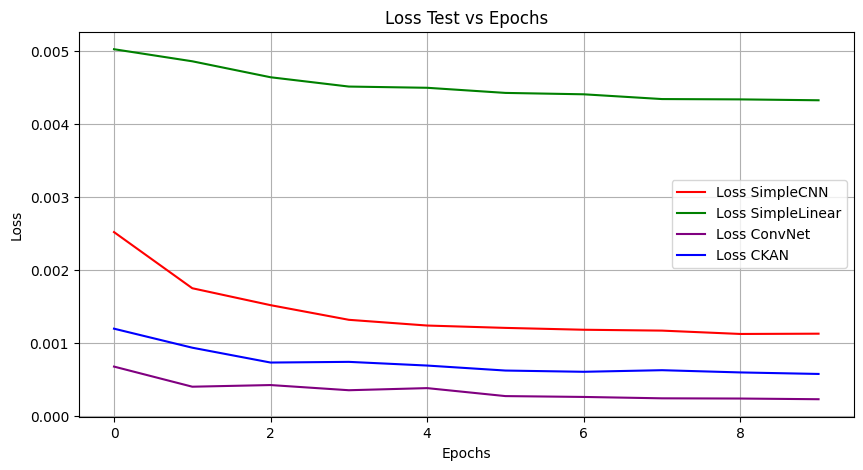

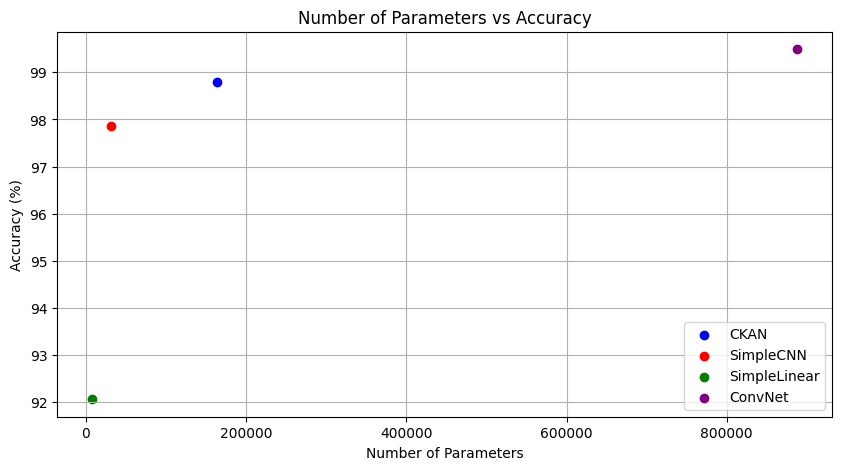

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(all_test_loss_SimpleCNN, label='Loss SimpleCNN', color='red')
plt.plot(all_test_loss_SimpleLinear, label='Loss SimpleLinear', color='green')
plt.plot(all_test_loss_ConvNet, label='Loss ConvNet', color='purple')
plt.plot(all_test_loss_KAN_Convolutional_Network, label='Loss CKAN', color='blue')
plt.plot(all_test_loss_SuperCKAN, label='Loss Super CKAN', color='yellow')
# plt.plot(all_test_loss_KKAN_Convolutional_Network, label='Loss KKAN', color='orange')
plt.title('Loss Test vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

param_counts = count_parameters(model)
plt.figure(figsize=(10, 5))
# Gráfico de Número de Parámetros vs Exactitud
plt.scatter(count_parameters(model_KAN_Convolutional_Network), max(all_test_accuracy_KAN_Convolutional_Network), color='blue', label='CKAN')
# plt.scatter(count_parameters(model_KKAN_Convolutional_Network), max(all_test_accuracy_KKAN_Convolutional_Network), color='orange', label='KKAN')
plt.scatter(count_parameters(model_SimpleCNN), max(all_test_accuracy_SimpleCNN), color='red', label='SimpleCNN')
plt.scatter(count_parameters(model_SimpleLinear), max(all_test_accuracy_SimpleLinear), color='green', label='SimpleLinear')
plt.scatter(count_parameters(model_ConvNet), max(all_test_accuracy_ConvNet), color='purple', label='ConvNet')

plt.scatter(count_parameters(model_SuperCKAN), max(all_test_accuracy_SuperCKAN), color='yellow', label='Super CKAN')

plt.title('Number of Parameters vs Accuracy')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.legend() 
plt.grid(True)
plt.show()


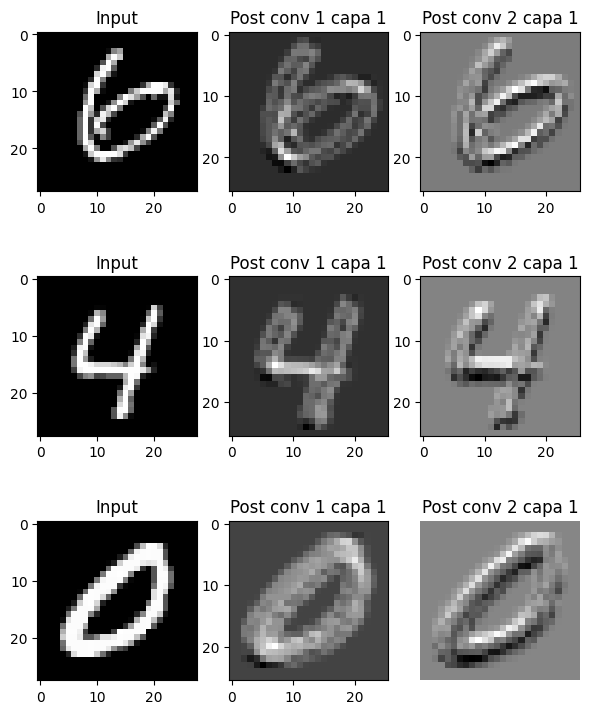

In [17]:
import matplotlib.pyplot as plt
rows = 3
fig, ax  = plt.subplots(nrows = rows ,ncols = 3,figsize =(7,9))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(mnist_test), size=(1,)).item()
        img, label = mnist_test[sample_idx]

        post_conv = model.conv1.forward(img.unsqueeze(0).to(device))
        #print(post_conv[0,0].shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("Input")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post conv 1 capa 1")
        ax[row][2].imshow(post_conv[0,1].cpu(), cmap="gray")
        ax[row][2].set_title("Post conv 2 capa 1")

torch.Size([1, 25, 11, 11])
torch.Size([1, 25, 11, 11])
torch.Size([1, 25, 11, 11])


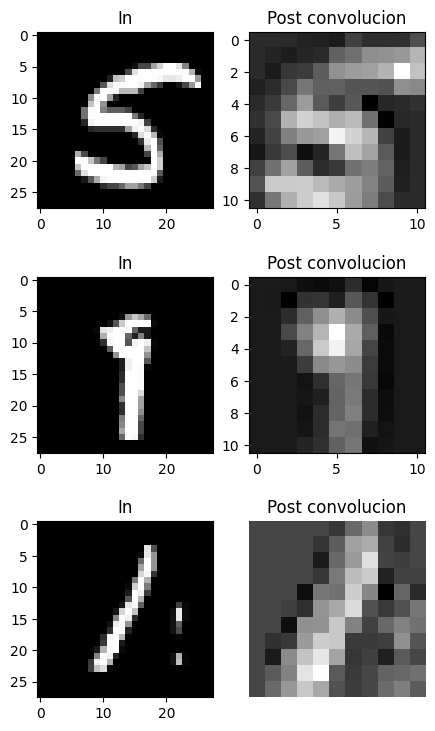

In [18]:
import matplotlib.pyplot as plt
rows =3
fig, ax  = plt.subplots(nrows = rows ,ncols = 2,figsize =(5,9))
pool = nn.MaxPool2d(kernel_size=(2, 2))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(mnist_test), size=(1,)).item()
        img, label = mnist_test[sample_idx]

        post_conv = pool(model.conv1.forward(img.unsqueeze(0).to(device)))
        post_conv = model.conv2.forward(post_conv) 
        
        print(post_conv.shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("In")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post convolucion")
